In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing libararies and files

In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install impyute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from impyute.imputation.cs import fast_knn # for imputing missing values

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping  
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses, optimizers

# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

from functools import partial

In [ ]:
# importing data sets
df_survey_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathn/Surveydata_train.csv')
df_survey_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathn/Surveydata_test.csv')
df_travel_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathn/Traveldata_train.csv')
df_travel_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathn/Traveldata_test.csv')

# Exploratory Data Analysis

## Initial exploration

In [ ]:
df_travel_train.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0
3,98800004,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0
4,98800005,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0


In [ ]:
df_travel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


In [ ]:
df_travel_train.describe()

,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
count,9.437900e+04,94346.000000,94379.000000,94322.000000,94022.000000
mean,9.884719e+07,39.419647,1978.888185,14.647092,15.005222
std,2.724501e+04,15.116632,1027.961019,38.138781,38.439409
min,9.880000e+07,7.000000,50.000000,0.000000,0.000000
25%,9.882360e+07,27.000000,1359.000000,0.000000,0.000000
50%,9.884719e+07,40.000000,1923.000000,0.000000,0.000000
75%,9.887078e+07,51.000000,2538.000000,12.000000,13.000000
max,9.889438e+07,85.000000,6951.000000,1592.000000,1584.000000


In [ ]:
df_travel_train.isna().any()

ID                         False
Gender                      True
Customer_Type               True
Age                         True
Type_Travel                 True
Travel_Class               False
Travel_Distance            False
Departure_Delay_in_Mins     True
Arrival_Delay_in_Mins       True
dtype: bool

**observations:** 
The dataset contains about 95k cases. 
Only the Travel_Class and Travel_Distance columns do not contain missing values.
The customer ID column is unlikely to provide useful information, and can be dropped.

In [ ]:
df_survey_train.head()

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent
3,98800004,0,Acceptable,Ordinary,Needs Improvement,NaN,Needs Improvement,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable
4,98800005,1,Acceptable,Ordinary,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good


In [ ]:
df_survey_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

In [ ]:
df_survey_train.describe()

,ID,Overall_Experience
count,9.437900e+04,94379.000000
mean,9.884719e+07,0.546658
std,2.724501e+04,0.497821
min,9.880000e+07,0.000000
25%,9.882360e+07,0.000000
50%,9.884719e+07,1.000000
75%,9.887078e+07,1.000000
max,9.889438e+07,1.000000


In [ ]:
df_survey_train.isna().any()

ID                         False
Overall_Experience         False
Seat_Comfort                True
Seat_Class                 False
Arrival_Time_Convenient     True
Catering                    True
Platform_Location           True
Onboard_Wifi_Service        True
Onboard_Entertainment       True
Online_Support              True
Ease_of_Online_Booking      True
Onboard_Service             True
Legroom                     True
Baggage_Handling            True
CheckIn_Service             True
Cleanliness                 True
Online_Boarding             True
dtype: bool

**observations:**
The travel and survey dataframes contian the same number of elements.
Most columns have missing values.
The two datasets can be joined on customer ID

## Visualized Exploration

In [ ]:
def bar_plot(df, column):
  print(df[column].value_counts(dropna=False))
  df[column].value_counts(dropna=False).plot(kind='bar')
  plt.show()

Loyal Customer       69823
Disloyal Customer    15605
NaN                   8951
Name: Customer_Type, dtype: int64


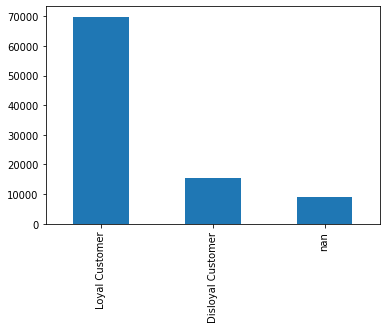

In [ ]:
bar_plot(df_train, 'Customer_Type')

Business Travel    58617
Personal Travel    26536
NaN                 9226
Name: Type_Travel, dtype: int64


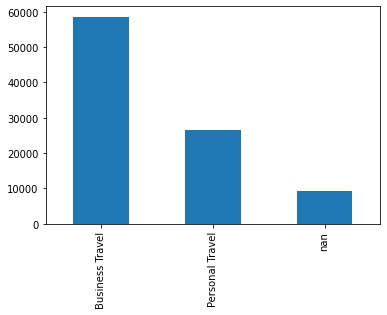

In [ ]:
bar_plot(df_train, 'Type_Travel')

Eco         49342
Business    45037
Name: Travel_Class, dtype: int64


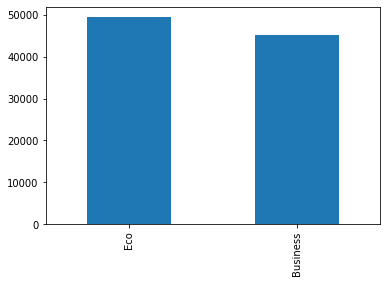

In [ ]:
bar_plot(df_train, 'Travel_Class')

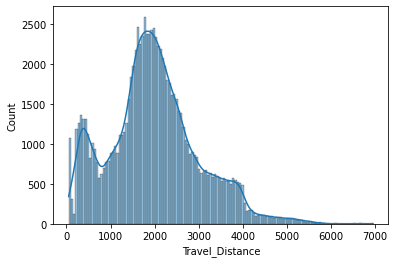

In [ ]:
sns.histplot(df_train.Travel_Distance, kde=True)
plt.show()

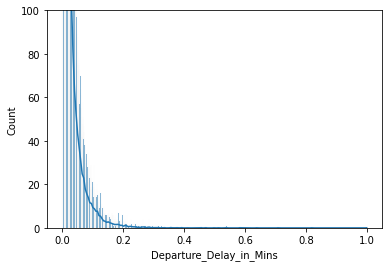

In [ ]:
sns.histplot(df_train.Departure_Delay_in_Mins, kde=True)
plt.ylim(0, 100)
plt.show()

**observations:** the departure delay variable appears to decay exponentially. Transforming this data may improve model performance.

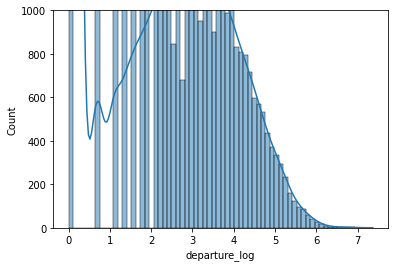

In [ ]:
df_exp = pd.DataFrame()
df_exp['departure_log'] = np.log(df_travel_train['Departure_Delay_in_Mins'], where=(df_travel_train['Departure_Delay_in_Mins'] != 0))
sns.histplot(df_exp.departure_log, kde=True)
plt.ylim(0, 1000)
plt.show()

plotting the log of departure dealys has resulted in a set that looks much more normal

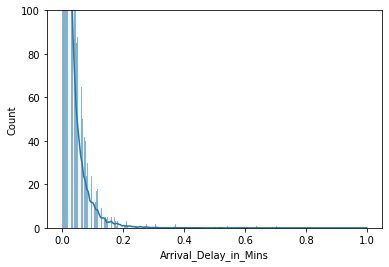

In [ ]:
sns.histplot(df_train.Arrival_Delay_in_Mins, kde=True)
plt.ylim(0, 100)
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


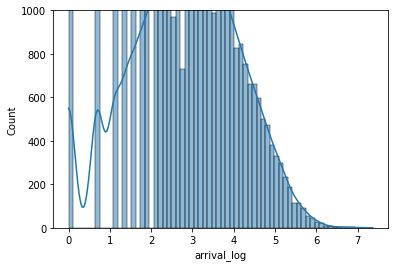

In [ ]:
df_exp = pd.DataFrame()
df_exp['arrival_log'] = np.log(df_travel_train['Arrival_Delay_in_Mins'])
sns.histplot(df_exp.arrival_log, kde=True)
plt.ylim(0, 1000)
plt.show()

taking the log of arrival delays also makes the feature more normally distributed

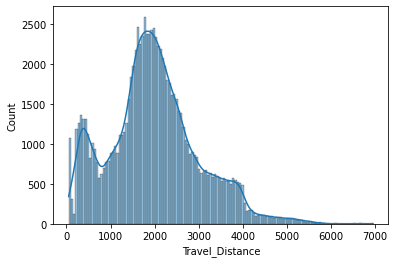

In [ ]:
sns.histplot(df_travel_train.Travel_Distance, kde=True)
plt.show()

Good                 22835
Excellent            20968
Acceptable           20118
Needs Improvement    19596
Poor                 10741
Extremely Poor          91
NaN                     30
Name: Onboard_Wifi_Service, dtype: int64


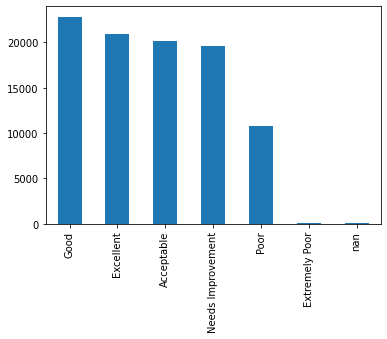

In [ ]:
bar_plot(df_train, 'Onboard_Wifi_Service')

1    51593
0    42786
Name: Overall_Experience, dtype: int64


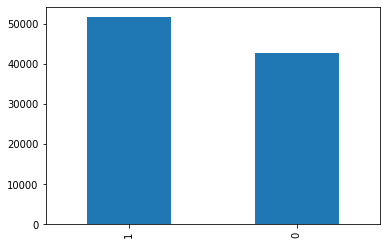

In [ ]:
bar_plot(df_train, 'Overall_Experience')

In [ ]:
df_train.isna().sum()/len(df_train)

ID                         0.000000
Gender                     0.000816
Customer_Type              0.094841
Age                        0.000350
Type_Travel                0.097755
Travel_Class               0.000000
Travel_Distance            0.000000
Departure_Delay_in_Mins    0.000604
Arrival_Delay_in_Mins      0.003783
Overall_Experience         0.000000
Seat_Comfort               0.000646
Seat_Class                 0.000000
Arrival_Time_Convenient    0.094619
Catering                   0.092616
Platform_Location          0.000318
Onboard_Wifi_Service       0.000318
Onboard_Entertainment      0.000191
Online_Support             0.000964
Ease_of_Online_Booking     0.000773
Onboard_Service            0.080537
Legroom                    0.000954
Baggage_Handling           0.001505
CheckIn_Service            0.000816
Cleanliness                0.000064
Online_Boarding            0.000064
dtype: float64

**observations:**
every column contains at least one missing value. However, no column is missing more than 10% of their values, meaning imputation is a good choice for this dataset

# Preparing Data for Model Building

## Feature Engineering

In [ ]:
# Find the logs of departure and arrival delays
df_travel_train['Departure_Delay_in_Mins'] = np.log(df_travel_train['Departure_Delay_in_Mins'])
df_travel_train['Arrival_Delay_in_Mins'] = np.log(df_travel_train['Arrival_Delay_in_Mins'])
df_travel_test['Departure_Delay_in_Mins'] = np.log(df_travel_test['Departure_Delay_in_Mins'])
df_travel_test['Arrival_Delay_in_Mins'] = np.log(df_travel_test['Arrival_Delay_in_Mins'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


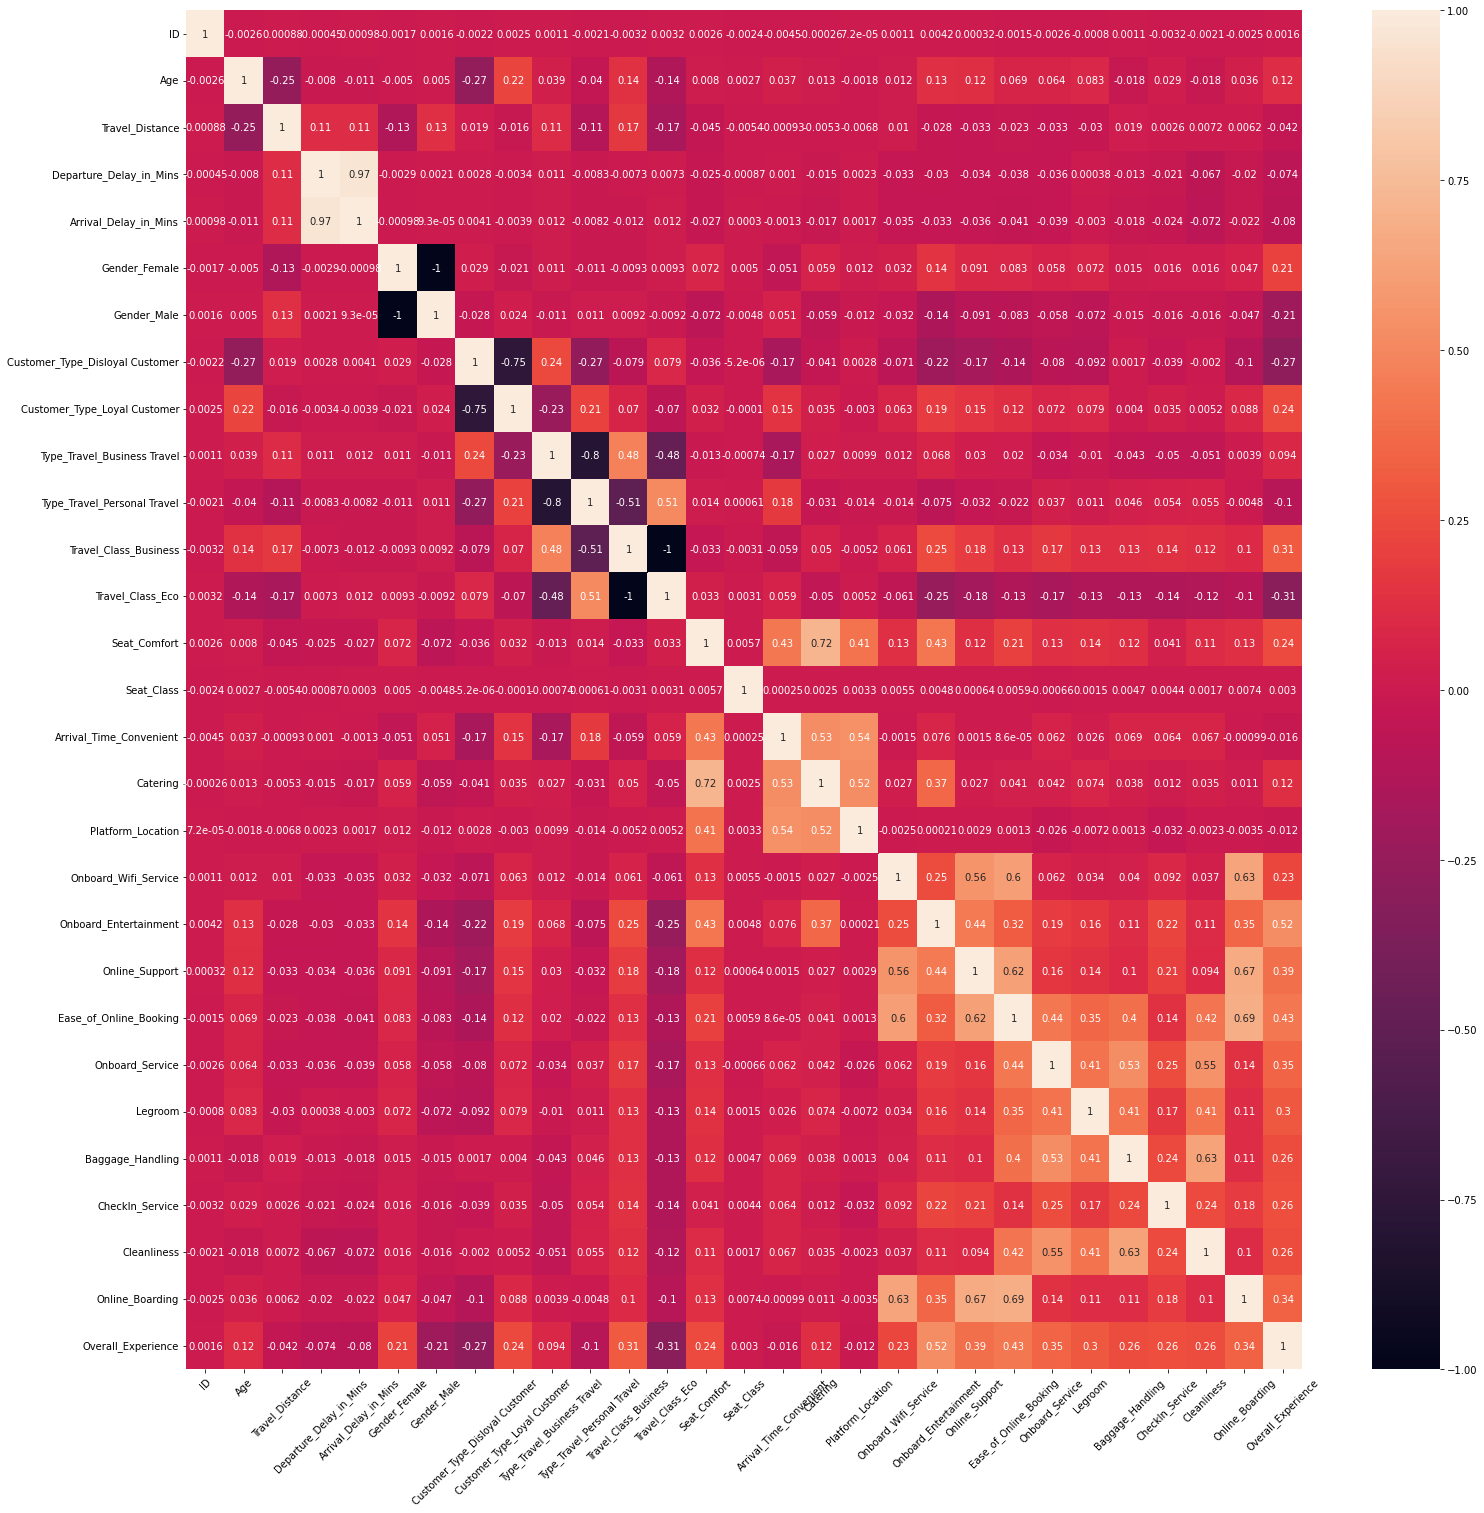

In [ ]:
plt.figure(figsize=(25, 25))
corr = df_train.corr()
sns.heatmap(corr, annot=True)
plt.xticks(rotation=45)
plt.show()

## Ordinal Encoding Categorical Variables

In [ ]:
# dictionary for how values should be encoded
encode_dict = {'Extremely Poor':0,
                'Poor':1,
                'Needs Improvement':2,
                'Acceptable':3,
                'Good':4,
                'Excellent':5,
                'Very Inconvenient':0,
                'Inconvenient':1,
                'Needs Improvement':2,
                'Manageable':3,
                'Convenient':4,
                'Very Convenient':5,
                'Green Car':1,
                'Ordinary':0}

In [ ]:
# encoding the survey training data
df_survey_train_encoded = df_survey_train.drop(['ID', 'Overall_Experience'], axis=1)
for x in df_survey_train_encoded:
  df_survey_train_encoded[x] = df_survey_train_encoded[x].map(encode_dict)

df_survey_train_encoded['ID'] = df_survey_train['ID']
df_survey_train_encoded['Overall_Experience'] = df_survey_train['Overall_Experience']

In [ ]:
# encoding the survey testing data
df_survey_test_encoded = df_survey_test.drop(['ID'], axis=1)
for x in df_survey_test_encoded:
  df_survey_test_encoded[x] = df_survey_test_encoded[x].map(encode_dict)
  
df_survey_test_encoded['ID'] = df_survey_test['ID']

## One Hot Encoding Categorical Variables

In [ ]:
# encoding the travel train and test data
df_travel_train = pd.get_dummies(df_travel_train)
df_travel_test = pd.get_dummies(df_travel_test)

## Normalizing Continuous Variables

In [ ]:
# Using the MinMax Scaler
scaler = MinMaxScaler()

# Scaling the train and test sets
df_travel_train_normalized = scaler.fit_transform(df_travel_train)
df_travel_test_normalized = scaler.fit_transform(df_travel_test)

# converting arrays back into dataframes
df_travel_train_normalized = pd.DataFrame(df_travel_train_normalized, columns=df_travel_train.columns)
df_travel_test_normalized = pd.DataFrame(df_travel_test_normalized, columns=df_travel_test.columns)

# fixing the id column
df_travel_train_normalized['ID'] = df_travel_train['ID']
df_travel_test_normalized['ID'] = df_travel_test['ID']

## Merging the Travel and Survey set

In [ ]:
df_train = df_travel_train_normalized.merge(df_survey_train_encoded, on='ID')
df_test = df_travel_test_normalized.merge(df_survey_test_encoded, on='ID')

## Imputing Missing Values

In [ ]:
# imputing missing values for the training set
df_train_imputed = fast_knn(df_train.values, k=30) # imputing missing values
df_train_imputed = pd.DataFrame(df_train_imputed, columns=df_train.columns) # reconverting to dataframe

In [ ]:
# imputing missing values for the testing set
df_test_imputed = fast_knn(df_test.values, k=30)
df_test_imputed = pd.DataFrame(df_test_imputed, columns=df_test.columns)

## Creating Training and Test sets

In [ ]:
X_train = df_train_imputed.drop(['ID', 'Overall_Experience'], axis=1)
y_train = df_train['Overall_Experience']
X_test = df_test_imputed.drop(['ID'], axis=1)
# X_train = df_train.drop(['ID', 'Overall_Experience'], axis=1)
# y_train = df_train['Overall_Experience']
# X_test = df_test.drop(['ID'], axis=1)

# Model Building

## Logistic Regression

In [ ]:
lr = LogisticRegression()

parameters = {
    'penalty': ['l1'],
    'class_weight': ['balanced'],
    'solver': ['saga'],
    'max_iter': [2000]
}

scorer = make_scorer(accuracy_score)

grid = GridSearchCV(lr, parameters, scoring=scorer, cv=3, verbose=3)
grid.fit(X_train, y_train)

lr_tuned = grid.best_estimator_
lr_tuned

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/3] END class_weight=balanced, max_iter=2000, penalty=l1, solver=saga;, score=0.857 total time= 4.7min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3] END class_weight=balanced, max_iter=2000, penalty=l1, solver=saga;, score=0.850 total time= 4.7min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3] END class_weight=balanced, max_iter=2000, penalty=l1, solver=saga;, score=0.853 total time= 4.7min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(class_weight='balanced', max_iter=2000, penalty='l1',
                   solver='saga')

In [ ]:
y_pred_lr_tuned = lr_tuned.predict(X_test)

## Decision Tree

In [ ]:
dt = DecisionTreeClassifier()

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 50],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

scorer = make_scorer(accuracy_score)
grid = GridSearchCV(dt, parameters, scoring=scorer, cv=5, verbose=5)

grid.fit(X_train, y_train)
dt_tuned = grid.best_estimator_
dt_tuned

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.924 total time=   1.1s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.922 total time=   1.0s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.921 total time=   1.0s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.921 total time=   1.0s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.922 total time=   1.0s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10;, score=0.924 total time=   1.0s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=50, min_samples_leaf=2, min_samples_split=10)

In [ ]:
y_pred_dt_tuned = dt_tuned.predict(X_test)

## Random Forest

In [ ]:
rf = RandomForestClassifier()

parameters = {
    'n_estimators': [1000],
    'criterion': ['gini'],
    'max_depth': [60],
    'class_weight': ['balanced_subsample'],
    'min_samples_split': [5],
}

scorer = make_scorer(accuracy_score)

grid = GridSearchCV(rf, parameters, scoring=scorer, cv=5, verbose=3)
grid.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
rf_tuned

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END class_weight=balanced_subsample, criterion=gini, max_depth=60, min_samples_split=5, n_estimators=1000;, score=0.952 total time= 2.1min
[CV 2/5] END class_weight=balanced_subsample, criterion=gini, max_depth=60, min_samples_split=5, n_estimators=1000;, score=0.954 total time= 2.1min
[CV 3/5] END class_weight=balanced_subsample, criterion=gini, max_depth=60, min_samples_split=5, n_estimators=1000;, score=0.954 total time= 2.2min
[CV 4/5] END class_weight=balanced_subsample, criterion=gini, max_depth=60, min_samples_split=5, n_estimators=1000;, score=0.954 total time= 2.4min
[CV 5/5] END class_weight=balanced_subsample, criterion=gini, max_depth=60, min_samples_split=5, n_estimators=1000;, score=0.954 total time= 2.7min


RandomForestClassifier(class_weight='balanced_subsample', max_depth=60,
                       min_samples_split=5, n_estimators=1000)

In [ ]:
rf_tuned.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 60,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
y_pred_rf_tuned = rf_tuned.predict(X_test)
submission = pd.DataFrame([df_test.ID, y_pred_rf_tuned]).T
submission.to_csv('submission.csv')
!cp submission.csv "drive/My Drive/"

## XGBooost

In [ ]:
xgb = xgboost.XGBRFClassifier()

parameters = {
    'booster': ['gbtree',],
    'n_estimators': [100],
    'subsample': [0.7],
    'learning_rate': [0.1],
    'max_depth': [6, 10],
    'reg_lambda': [1, 3]
}

scorer = make_scorer(accuracy_score)

grid = GridSearchCV(xgb, parameters, scoring=scorer, cv=5, verbose=3)
grid.fit(X_train, y_train)

xgb_tuned = grid.best_estimator_
y_pred_xgb_tuned = xgb_tuned.predict(X_test)

# saving submission
submission = pd.DataFrame([df_test.ID, np.array(y_pred_xgb_tuned)]).T
submission.to_csv('submission.csv')
!cp submission.csv "drive/My Drive/"

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END booster=gbtree, learning_rate=0.1, max_depth=6, n_estimators=100, reg_lambda=1, subsample=0.7;, score=0.908 total time=  16.6s
[CV 2/5] END booster=gbtree, learning_rate=0.1, max_depth=6, n_estimators=100, reg_lambda=1, subsample=0.7;, score=0.908 total time=  16.5s
[CV 3/5] END booster=gbtree, learning_rate=0.1, max_depth=6, n_estimators=100, reg_lambda=1, subsample=0.7;, score=0.908 total time=  16.6s
[CV 4/5] END booster=gbtree, learning_rate=0.1, max_depth=6, n_estimators=100, reg_lambda=1, subsample=0.7;, score=0.909 total time=  16.6s
[CV 5/5] END booster=gbtree, learning_rate=0.1, max_depth=6, n_estimators=100, reg_lambda=1, subsample=0.7;, score=0.909 total time=  16.5s
[CV 1/5] END booster=gbtree, learning_rate=0.1, max_depth=6, n_estimators=100, reg_lambda=3, subsample=0.7;, score=0.908 total time=  17.2s
[CV 2/5] END booster=gbtree, learning_rate=0.1, max_depth=6, n_estimators=100, reg_lambda=3, subsamp

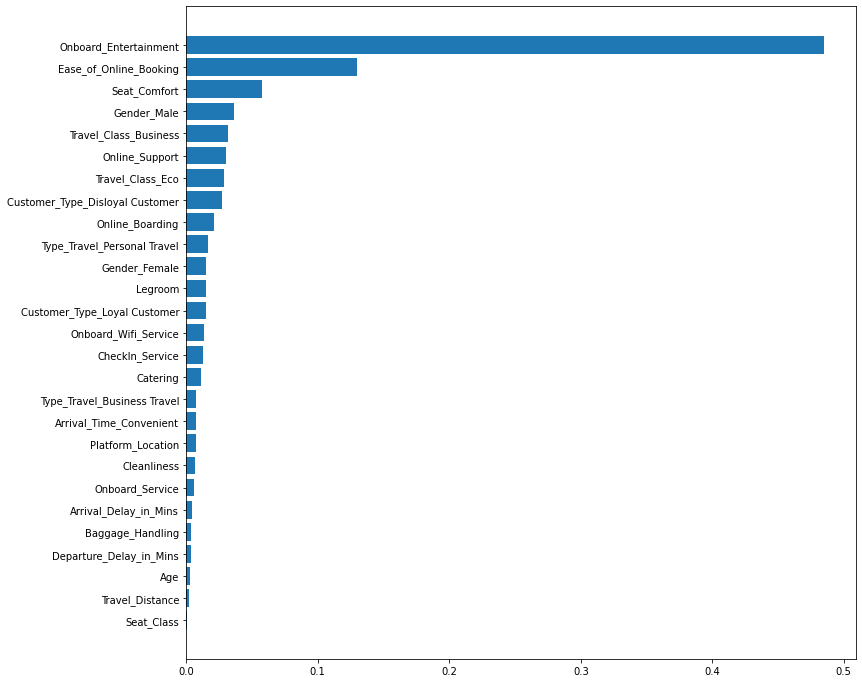

In [ ]:
plt.figure(figsize=(12, 12))
sorted = xgb_tuned.feature_importances_.argsort()
plt.barh(X_train.columns[sorted], xgb_tuned.feature_importances_[sorted])
plt.show()

## Artificial Neural Network

### Model 1

In [ ]:
y_train_encoded = pd.get_dummies(y_train)
X_train_array = np.array(X_train)

In [ ]:
model1 = Sequential()

model1.add(Dense(64, activation='relu', input_shape=(27,)))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))
model1.add(Dense(32, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))
model1.add(Dense(16, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))
model1.add(Dense(2, activation='sigmoid'))

optimizer = SGD(learning_rate=0.01, momentum=0.9)
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 64)                1792      
                                                                 
 batch_normalization_14 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_15 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 32)               

In [ ]:
# training the the ANN model
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history1 = model1.fit(X_train,
                    y_train_encoded,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[mc])



Epoch 1/30
1170/1180 [============================>.] - ETA: 0s - loss: 0.3575 - accuracy: 0.8512
Epoch 1: val_accuracy improved from -inf to 0.87095, saving model to best_model.h5
1180/1180 [==============================] - 7s 5ms/step - loss: 0.3573 - accuracy: 0.8513 - val_loss: 0.2982 - val_accuracy: 0.8709
Epoch 2/30
1171/1180 [============================>.] - ETA: 0s - loss: 0.3190 - accuracy: 0.8702
Epoch 2: val_accuracy improved from 0.87095 to 0.89606, saving model to best_model.h5
1180/1180 [==============================] - 7s 6ms/step - loss: 0.3194 - accuracy: 0.8701 - val_loss: 0.2452 - val_accuracy: 0.8961
Epoch 3/30
1173/1180 [============================>.] - ETA: 0s - loss: 0.3084 - accuracy: 0.8750
Epoch 3: val_accuracy did not improve from 0.89606
1180/1180 [==============================] - 6s 5ms/step - loss: 0.3084 - accuracy: 0.8751 - val_loss: 0.2518 - val_accuracy: 0.8916
Epoch 4/30
1175/1180 [============================>.] - ETA: 0s - loss: 0.3163 - accura

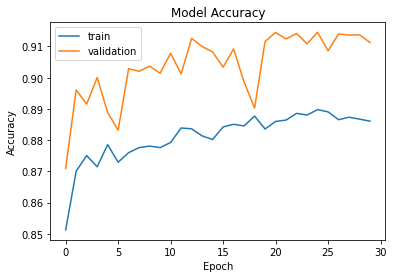

In [ ]:
# plotting the history of the loss function
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred_ann = model1.predict(X_test)

1113/1113 [==============================] - 2s 2ms/step


In [ ]:
y_pred_ann_list = []
for x in y_pred_ann:
  if x[0] > x[1]:
    y_pred_ann_list.append(0)
  else:
    y_pred_ann_list.append(1)

### Model 2

In [ ]:
model2 = Sequential()

model2.add(Dense(128, activation='relu', input_shape=(27,)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(16, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(2, activation='sigmoid'))

optimizer = SGD(learning_rate=0.005, momentum=0.9)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 128)               3584      
                                                                 
 batch_normalization_17 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_18 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 64)               

In [ ]:
# training the the ANN model
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history2 = model2.fit(X_train,
                    y_train_encoded,
                    epochs=60,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[mc])


Epoch 1/60
2356/2360 [============================>.] - ETA: 0s - loss: 0.3514 - accuracy: 0.8522
Epoch 1: val_accuracy improved from -inf to 0.90040, saving model to best_model.h5
2360/2360 [==============================] - 16s 6ms/step - loss: 0.3512 - accuracy: 0.8523 - val_loss: 0.2443 - val_accuracy: 0.9004
Epoch 2/60
2355/2360 [============================>.] - ETA: 0s - loss: 0.2868 - accuracy: 0.8811
Epoch 2: val_accuracy improved from 0.90040 to 0.90755, saving model to best_model.h5
2360/2360 [==============================] - 15s 6ms/step - loss: 0.2868 - accuracy: 0.8811 - val_loss: 0.2091 - val_accuracy: 0.9076
Epoch 3/60
2353/2360 [============================>.] - ETA: 0s - loss: 0.2699 - accuracy: 0.8875
Epoch 3: val_accuracy improved from 0.90755 to 0.91645, saving model to best_model.h5
2360/2360 [==============================] - 14s 6ms/step - loss: 0.2700 - accuracy: 0.8875 - val_loss: 0.2006 - val_accuracy: 0.9165
Epoch 4/60
2358/2360 [===========================

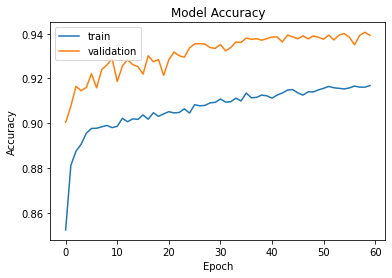

In [ ]:
# plotting the history of the loss function
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred_ann2 = model2.predict(X_test)
y_pred_ann_list = []
for x in y_pred_ann2:
  if x[0] > x[1]:
    y_pred_ann_list.append(0)
  else:
    y_pred_ann_list.append(1)

1113/1113 [==============================] - 2s 2ms/step


### Model 3

In [ ]:
model3 = Sequential()

model3.add(Dense(128, activation='relu', input_shape=(27,)))
model3.add(BatchNormalization())
model3.add(Dropout(0.1))
model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.1))
model3.add(Dense(32, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.1))
model3.add(Dense(16, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.1))
model3.add(Dense(8, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.1))
model3.add(Dense(2, activation='sigmoid'))

optimizer = SGD(learning_rate=0.005, momentum=0.9)
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 128)               3584      
                                                                 
 batch_normalization_41 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_41 (Dropout)        (None, 128)               0         
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_42 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_42 (Dropout)        (None, 64)              

In [ ]:
# training the the ANN model
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history3 = model3.fit(X_train,
                    y_train_encoded,
                    epochs=75,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[mc])

Epoch 1/75
2354/2360 [============================>.] - ETA: 0s - loss: 0.3288 - accuracy: 0.8623
Epoch 1: val_accuracy improved from -inf to 0.90544, saving model to best_model.h5
2360/2360 [==============================] - 20s 8ms/step - loss: 0.3288 - accuracy: 0.8622 - val_loss: 0.2221 - val_accuracy: 0.9054
Epoch 2/75
2353/2360 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.8905
Epoch 2: val_accuracy improved from 0.90544 to 0.91338, saving model to best_model.h5
2360/2360 [==============================] - 16s 7ms/step - loss: 0.2610 - accuracy: 0.8905 - val_loss: 0.2061 - val_accuracy: 0.9134
Epoch 3/75
2353/2360 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.8952
Epoch 3: val_accuracy improved from 0.91338 to 0.92694, saving model to best_model.h5
2360/2360 [==============================] - 18s 7ms/step - loss: 0.2488 - accuracy: 0.8952 - val_loss: 0.1774 - val_accuracy: 0.9269
Epoch 4/75
2353/2360 [===========================

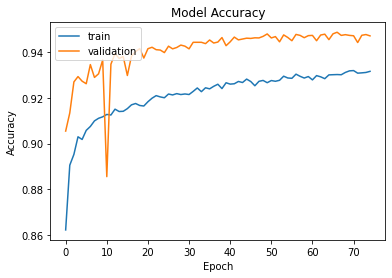

In [ ]:
# plotting the history of the loss function
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred_ann3 = model3.predict(X_test)
y_pred_ann_list = []
for x in y_pred_ann3:
  if x[0] > x[1]:
    y_pred_ann_list.append(0)
  else:
    y_pred_ann_list.append(1)

1113/1113 [==============================] - 2s 2ms/step


# Creating Submission File

In [ ]:
submission = pd.DataFrame([df_test.ID, np.array(y_pred_ann_list)]).T
submission.to_csv('submission.csv')
!cp submission.csv "drive/My Drive/"